In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
import pickle
from numba import njit
from scipy.stats import skew
from scipy.stats import binom
from functools import partial
np.set_printoptions(suppress=True)

# Import our bayesflow lib
from deep_bayes.models import BayesFlow, InvariantNetwork
from deep_bayes.training import train_online
from deep_bayes.losses import maximum_likelihood_loss
from deep_bayes.viz import plot_true_est_scatter, plot_true_est_posterior
import deep_bayes.diagnostics as diag

C:\Users\User1\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User1\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User1\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User1\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [2]:
import tensorflow as tf
if tf.__version__.startswith('1'):
    tf.enable_eager_execution()

In [3]:
%matplotlib inline

# Helper functions

In [4]:
def plot_sbc(theta_samples, theta_test, param_names, bins=25, dpi=300,
            figsize=(24, 12), interval=0.99, show=True, filename=None, font_size=12):
    """
    Plots the simulation-based posterior checking histograms as advocated by Talts et al. (2018).
    """

    # Plot settings
    plt.rcParams['font.size'] = font_size
    N = int(theta_test.shape[0])
    

    f, axarr = plt.subplots(2, 4, figsize=figsize)
    axarr = axarr.flat

    # Compute ranks (using broadcasting)    
    ranks = np.sum(theta_samples < theta_test, axis=0)
    
    # Compute interval
    endpoints = binom.interval(interval, N, 1 / (bins+1))

    # Plot histograms
    for j in range(len(param_names)):
        
        # Add interval
        axarr[j].axhspan(endpoints[0], endpoints[1], facecolor='gray', alpha=0.3)
        axarr[j].axhline(np.mean(endpoints), color='gray', zorder=0, alpha=0.5)
        
        sns.histplot(ranks[:, j], kde=False, ax=axarr[j], color='#a34f4f', bins=bins, alpha=0.95)
        
        axarr[j].set_title(param_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
        if j == 0:
            axarr[j].set_xlabel('Rank statistic')
        axarr[j].get_yaxis().set_ticks([])
        axarr[j].set_ylabel('')
    
    f.tight_layout()
    
    # Show, if specified
    if show:
        plt.show()
        
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}.png".format(filename), dpi=dpi)

# Simulator

In [5]:
@njit
def diffusion_trial(v, a, kappa, t_sat, ndt_c, ndt_w, dt, max_steps):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    x = a * 0.5
    b_u = a
    b_l = 0

    # Simulate a single DM path
    while (x > b_l and x < b_u and n_steps < max_steps):

        # DDM equation
        x += v*dt + np.sqrt(dt) * np.random.normal()

        # Increment step
        n_steps += 1.0
        
        # Collapse boundaries
        t = dt * n_steps
        b_u = a - (a/2) * kappa * (t/(t + t_sat))
        b_l = (a/2) * kappa * (t/(t + t_sat))

    rt = n_steps * dt
    return rt + ndt_c if x >= b_l else -rt - ndt_w

@njit
def simulate_diffusion_condition(n_trials, v, a, kappa, t_sat, ndt_c, ndt_w, dt=0.001, max_steps=15000):
    """Simulates a diffusion process over an entire condition."""
    
    x = np.empty(n_trials)
    for i in range(n_trials):
        x[i] = diffusion_trial(v, a, kappa, t_sat, ndt_c, ndt_w, dt, max_steps)
    return x


@njit
def simulate_diffusion_2_conds(theta, n_trials, dt=0.001, max_steps=15000):
    """Simulates a diffusion process for 2 conditions with 7 parameters (v1, v2, a1, a2, ndt1, ndt2, zr=0.5)"""
    
    n_trials_c1 = n_trials[0]
    n_trials_c2 = n_trials[1]
    
    
    v1, v2, a1, a2, kappa, t_sat, ndt_c, ndt_w = theta
    rt_c1 = simulate_diffusion_condition(n_trials_c1, v1, a1, kappa, t_sat, ndt_c, ndt_w, dt, max_steps)
    rt_c2 = simulate_diffusion_condition(n_trials_c2, v2, a2, kappa, t_sat, ndt_c, ndt_w, dt, max_steps)
    rts = np.concatenate((rt_c1, rt_c2))
    return rts

def data_generator(batch_size, n_obs=None, to_tensor=True, n_obs_min=60, 
                   n_obs_max=60, include_criterion=True):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta) with the specified n_obs. If 
    n_obs is None, random number of trials for each condition are generated.
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    n_obs      : tuple (int, int) or None -- the numebr of observations to draw from p(x|theta)
                                  for each condition
    n_obs_min  : int -- the minimum number of observations per condition
    n_obs_max  : int -- the maximum number of observations per condition
    to_tensor  : boolean -- converts theta and x to tensors if True
    include_criterion : boolean -- whether to set RTs < 0.3 or RT > 10 to missing (0), as in IAT analysis
    ----------
    
    Output:
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from prior
    # theta is a np.array of shape (batch_size, theta_dim)
    theta = prior(batch_size)
    
    # Fixed or random number of DM samples
    if n_obs is None:
        n_obs = np.random.randint(n_obs_min, n_obs_max+1, 2)
    
    # Generate data
    # x is a np.ndarray of shape (batch_size x n_obs, x_dim)
    x = np.apply_along_axis(simulate_diffusion_2_conds, axis=1, arr=theta, n_trials=n_obs)
    
    # Mark bullshit data with 0
    if include_criterion:
        x[np.abs(x) < 0.3] = 0.
        x[np.abs(x) > 10] = 0.
    
    # Assign conditions
    cond_arr = np.stack( batch_size * [np.concatenate((np.zeros(n_obs[0]), np.ones(n_obs[1])))] )
    x = np.stack((x, cond_arr), axis=-1)
    
    # Convert to tensor, if specified 
    if to_tensor:
        theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
    return {'theta': theta, 'x': x}

Collapse factor lower boundary:  -1.3244594594594592
Collapse factor upper boundary:  1.3244594594594592


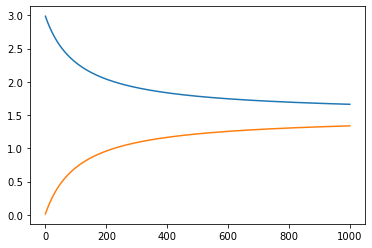

In [6]:
a = 3
kappa = 0.99
t_sat = 0.11
t = np.linspace(0.001, 1, 1000)

collapse_u = a - (a/2)*kappa * (t/(t + t_sat))


collapse_l = (a/2) * kappa * (t/(t + t_sat))

plt.plot(collapse_u)
plt.plot(collapse_l)

print('Collapse factor lower boundary: ', collapse_l[0] - collapse_l[-1])
print('Collapse factor upper boundary: ', collapse_u[0] - collapse_u[-1])

# Prior

In [7]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------
    
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Prior ranges for the simulator 
    # v ~ U(-7.0, 7.0)
    # a ~ U(0.1, 4.0)
    # kappa ~ U(0.01, 0.99)
    # t_sat ~ U(0.1, 3)
    # t0_p ~ U(0.1, 3.0)
    # t0_w ~ U(0.1, 7.0)
    theta = np.random.uniform(low=(0.1, 0.1, 0.1, 0.1, 0.01, 0.1, 0.1, 0.1), 
                              high=(7.0, 7.0, 4.0, 4.0, 0.99, 3.0, 3.0, 7.0), size=(batch_size, 8))
    return theta

# Summary Network Structure
Here, we will define the basic outline of a permutation-invariant neural network which maps raw reaction times data to outcomes.
<br>
See https://arxiv.org/pdf/1901.06082.pdf (p.28) for more details.

In [8]:
class InvariantModule(tf.keras.Model):
    """Implements an invariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, meta, pooler=tf.reduce_mean):
        """
        Creates an invariant function with mean pooling.
        ----------

        Arguments:
        meta : dict -- a dictionary with hyperparameter name - values
        """

        super(InvariantModule, self).__init__()


        self.module = tf.keras.Sequential([
            tf.keras.layers.Dense(**meta['dense_inv_args'])
            for _ in range(meta['n_dense_inv'])
        ])
        
        self.pooler = pooler
            

        self.post_pooling_dense = tf.keras.Sequential([
            tf.keras.layers.Dense(**meta['dense_inv_args'])
            for _ in range(meta['n_dense_inv'])
        ])

    def call(self, x):
        """
        Transofrms the input into an invariant representation.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        # Embed
        x_emb = self.module(x)

        # Pool representation
        pooled = self.pooler(x_emb, axis=1)
    
        # Increase representational power
        out = self.post_pooling_dense(pooled)
        return out


class EquivariantModule(tf.keras.Model):
    """Implements an equivariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, meta):
        """
        Creates an equivariant neural network consisting of a FC network with
        equal number of hidden units in each layer and an invariant module
        with the same FC structure.
        ----------

        Arguments:
        meta : dict -- a dictionary with hyperparameter name - values
        """

        super(EquivariantModule, self).__init__()

        self.module = tf.keras.Sequential([
            tf.keras.layers.Dense(**meta['dense_equiv_args'])
            for _ in range(meta['n_dense_equiv'])
        ])

        self.invariant_module = InvariantModule(meta)

    def call(self, x):
        """
        Transofrms the input into an equivariant representation.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x_inv = self.invariant_module(x)
        x_inv = tf.stack([x_inv] * int(x.shape[1]), axis=1) # Repeat x_inv n times
        x = tf.concat((x_inv, x), axis=-1)
        out = self.module(x)
        return out


class InvariantNetwork(tf.keras.Model):
    """
    Implements a network which parameterizes a
    permutationally invariant function according to Bloem-Reddy and Teh (2019).
    """

    def __init__(self, meta):
        """
        Creates a permutationally invariant network
        consisting of two equivariant modules and one invariant module.
        ----------

        Arguments:
        meta : dict -- hyperparameter settings for the equivariant and invariant modules
        """

        super(InvariantNetwork, self).__init__()

        self.equiv = tf.keras.Sequential([
            EquivariantModule(meta)
            for _ in range(meta['n_equiv'])
        ])
        self.inv = InvariantModule(meta)

    def call(self, x, **kwargs):
        """
        Transofrms the input into a permutationally invariant
        representation by first passing it through multiple equivariant
        modules in order to increase representational power.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the
        'samples' dimensions over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x = self.equiv(x)
        out = self.inv(x)
        return out

# Hyperparameter settings and model definition

In [9]:
# Neural network structure
summary_meta = {
    'dense_inv_args'   :  dict(units=64, activation='elu', kernel_initializer='glorot_normal'),
    'dense_equiv_args' :  dict(units=64, activation='elu', kernel_initializer='glorot_normal'),
    'dense_post_args'  :  dict(units=64, activation='elu', kernel_initializer='glorot_normal'),
    'n_equiv'          :  2,
    'n_dense_inv'      :  3,
    'n_dense_equiv'    :  3,
}

# Network hyperparameters
inv_meta = {
    'n_units': [128, 128, 128],
    'activation': 'elu',
    'w_decay': 0.00000,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 4

# Forward model hyperparameters
param_names = [r'$v_1$', r'$v_2$', r'$a_1$', r'$a_2$', r'$\kappa$', 
               r'$t_{0.5}$', r'$\tau_{c}$', r'$\tau_{w}$']
theta_dim = len(param_names)
n_test = 300
n_obs_max = 60
n_obs_min = 60
n_obs_test = (60, 60)

# Utility for online learning
data_gen = partial(data_generator, n_obs_min=n_obs_min, n_obs_max=n_obs_max)


# Training and optimizer hyperparameters
ckpt_file = "iat_bayesflow_collapsing"
batch_size = 64
epochs = 50
iterations_per_epoch = 1000
n_samples_posterior = 2000
clip_value = 5.

learning_rate = 0.001
if tf.__version__.startswith('1'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
else:
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)               

In [10]:
summary_net = InvariantNetwork(summary_meta)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

# Create Test Data

In [11]:
%%time
test_data = data_generator(n_test, n_obs=n_obs_test)

Wall time: 1.29 s


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


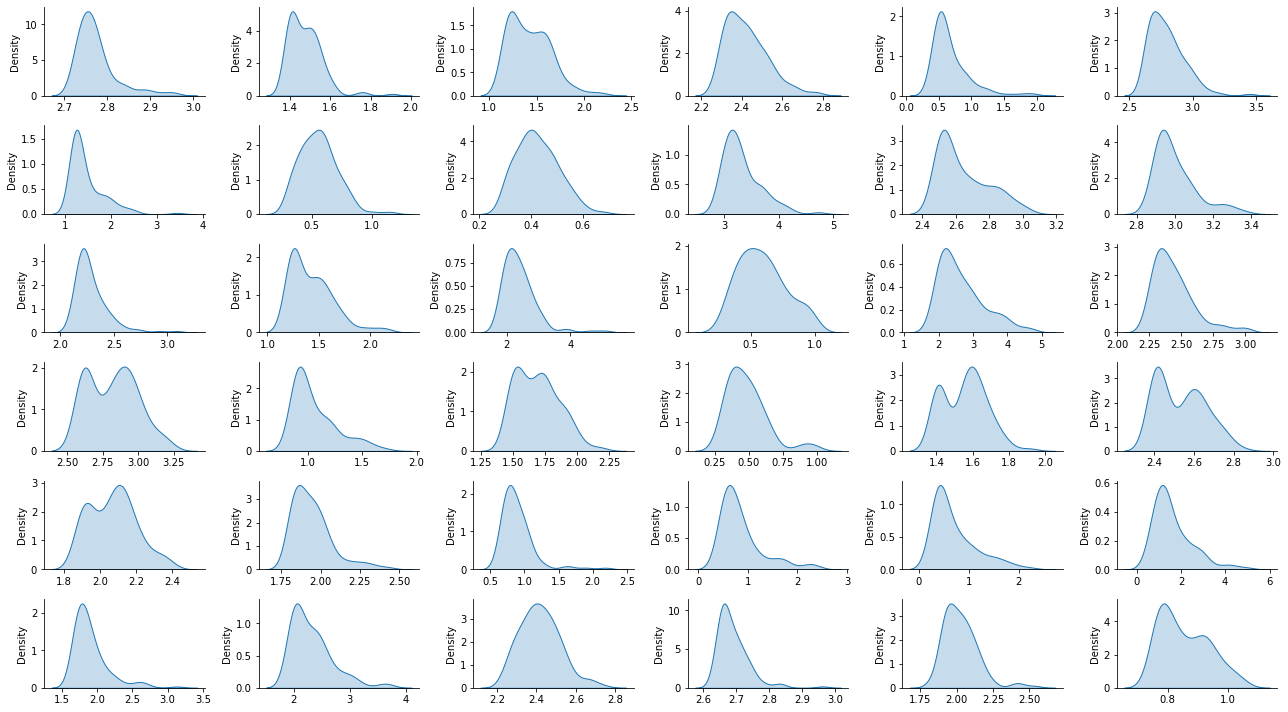

In [12]:
plot_data = data_generator(36, n_obs=(300, 300))
f, axarr = plt.subplots(6, 6, figsize=(18, 10))
for i in range(36):
    t_ = test_data['x'][i, :, :300][:, 0]
    t_ = t_[t_ > 0]
    sns.kdeplot(t_, ax=axarr.flat[i], shade=True)
    sns.despine(ax=axarr.flat[i])
f.tight_layout()

# Checkpoint manager
Used for saving/loading the model.

In [13]:
checkpoint = tf.train.Checkpoint(optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/iat_bayesflow_col', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/iat_bayesflow_col\ckpt-54


## Prepare data for inference - functions

In [14]:
def read_iat_rt_file(file_to_read, black_not_african):
    """
    Reads and preprocesses a single IAT file.
    """
    
    if black_not_african:
        pairs_to_retain = ['Black people/Bad,White people/Good', 
                            'White people/Bad,Black people/Good', 
                            'White people/Good,Black people/Bad', 
                            'Black people/Good,White people/Bad']
    else:
        pairs_to_retain =['African Americans/Bad,European Americans/Good', 
                            'European Americans/Bad,African Americans/Good', 
                            'European Americans/Good,African Americans/Bad', 
                            'African Americans/Good,European Americans/Bad']


    # We only need certain columsn from the data, so we can indicate pandas to only read
    # a subset of them and save memory. The problem is, that the data has been inappropriately
    # saved and when the header is read, there are whitespaces in the data, so we shall assume
    # that all relevant columns have the same order in all datafiles
    cols_to_use_str = ['block_number', 'block_pairing_definition', 'trial_latency', 'trial_error', 'session_id']
    cols_to_use_idx = [0, 3, 10, 11, 12]
    valid_values_error = [0, 1, '1', '0'] # Use for some datasets containing invalid values
    
    df = pd.read_csv(PATH + file_to_read, delimiter='\t', usecols=cols_to_use_idx)

    # Fix data handling 
    # There are whitespaces in the columns, to we need to get rid of them
    df.columns = [c.strip() for c in df.columns]
    assert all([c1 == c2 for c1, c2 in zip(df.columns, cols_to_use_str)]), 'Expected column order does not match!'
 
    # Retain only relevant pairs
    df = df[df['block_pairing_definition'].isin(pairs_to_retain)]
    print('Initial shape:', len(df.groupby('session_id')))

    # Remove id with no age
        
    df = df[df['session_id'].isin(outcomes['session_id'])]
    print('Removing no age ids:', len(df.groupby('session_id')))

    
    # Remove invalid ids
    df = df[df['trial_error'].isin(valid_values_error)]
    print('Removing invalid ids:', len(df.groupby('session_id')))

    
    # Ensure correct types
    df = df.astype({"block_number": int, 
                    "block_pairing_definition": str,
                    "trial_latency": int,
                    "trial_error": int})

      
    # Remove sessions with 0 latency
    zero_latency_id = df[df['trial_latency']==0]['session_id'].to_list()
    df = df[~df['session_id'].isin(zero_latency_id)]
    print('After excluding zero latency IDs:', len(df.groupby('session_id')))
    
    # Remove sessions with not exactly 120 trials
    not120trials_id = df.groupby('session_id').size()
    not120trials_id = not120trials_id[not120trials_id != 120].index.to_list()
    df = df[~df['session_id'].isin(not120trials_id)]
    print('After excluding less than 120 trials IDs:', len(df.groupby('session_id')))
    
    # Remove sessions with >50% errors
    fiftypercent_errors_id = df.groupby('session_id').mean()
    fiftypercent_errors_id = fiftypercent_errors_id[fiftypercent_errors_id['trial_error'] > 0.5].index.to_list()
    df = df[~df['session_id'].isin(fiftypercent_errors_id)]
    print('After excluding more than 50% error IDs:', len(df.groupby('session_id')))

    # Remove sessions with 0 errors
    zero_errors_id = df.groupby('session_id').sum()
    zero_errors_id = zero_errors_id[zero_errors_id['trial_error'] == 0].index.to_list()
    df = df[~df['session_id'].isin(zero_errors_id)]
    print('After excluding zero error IDs:', len(df.groupby('session_id')))


    # Convert RTs in ms
    df.loc[:, 'trial_latency'] = df['trial_latency'] / 1000

    # Code compatible vs incompatible
    # changes for different types of stimuli! (black/white vs african american/european american)
    if black_not_african:
        df['trial_compatible'] = np.where((df['block_pairing_definition'] == "Black people/Bad,White people/Good") | 
                                      (df['block_pairing_definition'] == 'White people/Good,Black people/Bad'), 1, 0)
    else:
        df['trial_compatible'] = np.where((df['block_pairing_definition'] == "African Americans/Bad,European Americans/Good") | 
                                      (df['block_pairing_definition'] == 'European Americans/Good,African Americans/Bad'), 1, 0)

    
    # Sort dataframe according to session id
    df = df.sort_values('session_id')
    
    # Convert rt dataset to dictionary (session_id - np.array of rt/errors/comopatible)
    df_rt_dict = df.groupby('session_id')['trial_latency'].apply(np.array).to_dict()
    df_err_dict = df.groupby('session_id')['trial_error'].apply(np.array).to_dict()
    df_comp_dict = df.groupby('session_id')['trial_compatible'].apply(np.array).to_dict()
    df_block_dict = df.groupby('session_id')['block_number'].apply(np.array).to_dict()
    
    rts_data = {}
    for k1, k2, k3, k4 in zip(df_rt_dict, df_err_dict, df_comp_dict, df_block_dict):
        assert k1 == k2 == k3 == k4, 'Key mismatch within the same dataset, something went wrong!'
        rts_data[k1] = np.c_[df_rt_dict[k1], df_err_dict[k1], df_comp_dict[k1], df_block_dict[k1]]
    return rts_data


def prepare_data(dataset_name, black_not_african):
    """
    Preprocesses a single IAT file and combines with outcomes.
    """    
    # Prepare a list for current chunk data/outcomes
    # Since we don't know how many will survive the next step
    # we initialize lists which we late convert to np.arrays

    X_arr = []
    y_arr = []
    
    # Read in file
    data_dict = read_iat_rt_file(dataset_name, black_not_african)
    print('Successfully read datafile', dataset_name, '.')
    print('Converting to X and y arrays...')

    # Loop through sessions and get those RT arrays for which we have outcomes
    for key in data_dict.keys():
        outcome = outcomes_dict.get(key)
        
        # Add only if outcome for the dataset is present
        if outcome is not None:
            
            # Add only if 120 trials and 2 outcomes present
            if data_dict[key].shape == (120, 4) and outcomes_dict[key].shape == (2,):
                X_arr.append(data_dict[key])
                y_arr.append(outcomes_dict[key])
            
    # X becomes a 3D array (N_datasets x 120 x 4)
    # y becomes a 2D array (N_datasets x 2)
    X_arr = np.stack(X_arr)
    y_arr = np.stack(y_arr)

    print('Final shape of RTs chunk (after once more excluding cases w/ missing age or trials): ', X_arr.shape)
    print('Final shape of outcomes chunk: ', y_arr.shape)
    
    return X_arr, y_arr


def data_cleaning_300 (X_test, y_test):
    """
    Get data in correct format and remove cases with more than 12 trials < 300 ms
    """        
    # Get X_test into the correct format:
    rts = np.where(X_test[:, :, 1], -X_test[:, :, 0], X_test[:, :, 0])
    comps = X_test[:, :, 2]
    X_test = np.stack((rts, comps), axis=2)

    # Exclusion criterion (< 0.3)
    idx_300 = (np.abs(X_test[:, :, 0]) < 0.3).sum(axis=1) <= 12
    X_test = X_test[idx_300, :, :]
    print('IDs with less than 12 trials >300 ms:', X_test.shape)

    # Keep only corresponding y
    y_test = y_test[idx_300, :]
    y_test = np.int64(y_test)
    
    # Set trials with latency <300 ms or >10 seconds to 0
    X_test[:,:,0][np.abs(X_test[:,:,0]) < .3] = 0
    X_test[:,:,0][np.abs(X_test[:,:,0]) > 10] = 0
    X_test = np.float32(X_test)

    return X_test, y_test


def compute_summaries(samples_dm):
    """
    Compute summary statistics and correlations
    """          
    param_means = samples_dm.mean(axis=0)
    param_medians = np.median(samples_dm,axis=0)   
    estimates = np.concatenate((param_means, param_medians), axis=1) 
    
    return estimates


def post_processing(X_test, estimates, param_means, y_test):
    """
    Delete datasets with out-of-prior parameter estimates (from data and estimates)
    """
    good_cases = ((param_means[:,0]>.1) & (param_means[:,0]<7.) & #v1 between .1 and 7
                  (param_means[:,1]>.1) & (param_means[:,1]<7.) & #v2 between .1 and 7
                  (param_means[:,2]>.1) & (param_means[:,2]<4.) & #a1 between .1 and 4
                  (param_means[:,3]>.1) & (param_means[:,3]<4.) & #a2 between .1 and 4
                  (param_means[:,4]>.01) & (param_means[:,4]<.99) & #kappa between .01 and .99
                  (param_means[:,5]>.1) & (param_means[:,5]<3.) & #t_sat between .1 and 3
                  (param_means[:,6]>.1) & (param_means[:,6]<3.) & #tplus between .1 and 3
                  (param_means[:,7]>.1) & (param_means[:,7]<7.))  #tminus between .1 and 7

    
 
    print("In prior-cases:", good_cases.shape)
    estimates_clean = estimates[good_cases,:]
    data_chunk_clean = X_test[good_cases,:,:]
    y_clean = y_test[good_cases,:]
    
    return data_chunk_clean, estimates_clean, y_clean


In [17]:
#Settings
# Path to data
PATH = 'D:/iat/data/'
# Path to outcomes
PATH_OUTCOME = 'D:/iat/outcomes/'

# where to save files
PATH_TO_SAVE = 'D:/iat/pickle_col/'

# Choose type of stimulus to process (Black/African American)
black_not_african = False

In [ ]:
# Read in outcomes, drop missing, sort
outcomes = pd.read_csv(PATH_OUTCOME + 'outcomes_with_id_161718.csv', header=0, na_values='NA')
outcomes = outcomes.dropna()
outcomes = outcomes.sort_values('session_id')

# Convert outcomes to a dictionary for instant lookup; use only cases containing age and session id
outcomes_id2_dict = outcomes.groupby('session_id')['id2'].apply(int).to_dict()
outcomes_age_dict = outcomes.groupby('session_id')['age'].apply(int).to_dict()


outcomes_dict = {}
for k1, k2 in zip(outcomes_id2_dict, outcomes_age_dict):
    assert k1 == k2 
    outcomes_dict[k1] = np.array([outcomes_id2_dict[k1], 
                                  outcomes_age_dict[k2]])
    
# Note, that outcomes dict will be a global dictionary

In [18]:
#This is where the magic happens

# 1. Store all data-set chunk names in a list
datasets = os.listdir(PATH)

# 2. For each chunk
for dataset_name in datasets:
    
    # 2.1 Load chunk
    X_test, y_test = prepare_data(dataset_name, black_not_african)
 
    # 2.2 Preprocess chunk 
    # 2.2.1 Apply IAT exclusion criteria (conservative)
    # 2.2.2 Format data for NN, negative coding
    # 2.2.3 Add 0s for <0.3, and >10
    X_test, y_test = data_cleaning_300(X_test, y_test)
      
    # 2.3 Estimate chunk
    samples_dm = np.concatenate([model.sample(x, n_samples=2000,
                                              to_numpy=True) for x in np.array_split(X_test, 20)], axis=1)
                
    # 2.4 Compute summaries: means, medians, stds, Q0.025, Q0.0975, post_corr
    estimates = compute_summaries(samples_dm)
    param_means = estimates[:,0:8]

    # 2.5 Post-processing 
        # 2.5.1 find inices of implausible (out of prior) parameter means
        # 2.5.2 remove from estimates
        # 2.5.3 remove from datasets
    data_chunk_clean, estimates_clean, y_clean = post_processing(X_test, estimates, param_means, y_test)
      
    # 2.6 Store everything together (serialized, pickle.dump) as a dict with keys 
    dict_to_store = {'data_array': data_chunk_clean, 'est_array': estimates_clean, "outcome_array": y_clean}
    pickle.dump(dict_to_store,
                open(PATH_TO_SAVE +str(black_not_african)+ str(dataset_name.replace('.txt', '.p') ),"wb"))
    print(str(dataset_name)+ " done")

# 3. Celebrate

Initial shape: 25680
Removing no age ids: 22686


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22686
After excluding zero latency IDs: 22576
After excluding less than 120 trials IDs: 22077
After excluding more than 50% error IDs: 22048
After excluding zero error IDs: 20615
Successfully read datafile 2016iat.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20615, 120, 4)
Final shape of outcomes chunk:  (20615, 2)
IDs with less than 12 trials >300 ms: (20435, 120, 2)
In prior-cases: (20435,)
2016iat.txt done
Initial shape: 25577
Removing no age ids: 22175


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22175
After excluding zero latency IDs: 22017
After excluding less than 120 trials IDs: 21630
After excluding more than 50% error IDs: 21601
After excluding zero error IDs: 20398
Successfully read datafile 2016iat2.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20398, 120, 4)
Final shape of outcomes chunk:  (20398, 2)
IDs with less than 12 trials >300 ms: (20170, 120, 2)
In prior-cases: (20170,)
2016iat2.txt done
Initial shape: 25602
Removing no age ids: 22378


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22378
After excluding zero latency IDs: 22210
After excluding less than 120 trials IDs: 21798
After excluding more than 50% error IDs: 21763
After excluding zero error IDs: 20624
Successfully read datafile 2016iat3.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20624, 120, 4)
Final shape of outcomes chunk:  (20624, 2)
IDs with less than 12 trials >300 ms: (20370, 120, 2)
In prior-cases: (20370,)
2016iat3.txt done
Initial shape: 25668
Removing no age ids: 21913


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 21913
After excluding zero latency IDs: 21785
After excluding less than 120 trials IDs: 21403
After excluding more than 50% error IDs: 21381
After excluding zero error IDs: 20134
Successfully read datafile 2016iat4.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20134, 120, 4)
Final shape of outcomes chunk:  (20134, 2)
IDs with less than 12 trials >300 ms: (19920, 120, 2)
In prior-cases: (19920,)
2016iat4.txt done
Initial shape: 2425
Removing no age ids: 2091
Removing invalid ids: 2091
After excluding zero latency IDs: 2086
After excluding less than 120 trials IDs: 2055
After excluding more than 50% error IDs: 2052
After excluding zero error IDs: 1887
Successfully read datafile 2016iat5.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (1887, 120, 4)
Final shape of outcomes chunk:  (1887, 2)
IDs with less than 12 tr

C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22219
After excluding zero latency IDs: 22091
After excluding less than 120 trials IDs: 21661
After excluding more than 50% error IDs: 21648
After excluding zero error IDs: 20292
Successfully read datafile 2017iat.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20292, 120, 4)
Final shape of outcomes chunk:  (20292, 2)
IDs with less than 12 trials >300 ms: (20073, 120, 2)
In prior-cases: (20073,)
2017iat.txt done
Initial shape: 25478
Removing no age ids: 22290


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22290
After excluding zero latency IDs: 22109
After excluding less than 120 trials IDs: 21721
After excluding more than 50% error IDs: 21698
After excluding zero error IDs: 20434
Successfully read datafile 2017iat10.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20434, 120, 4)
Final shape of outcomes chunk:  (20434, 2)
IDs with less than 12 trials >300 ms: (20209, 120, 2)
In prior-cases: (20209,)
2017iat10.txt done
Initial shape: 25497
Removing no age ids: 22361


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22361
After excluding zero latency IDs: 22143
After excluding less than 120 trials IDs: 21797
After excluding more than 50% error IDs: 21768
After excluding zero error IDs: 20572
Successfully read datafile 2017iat11.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20572, 120, 4)
Final shape of outcomes chunk:  (20572, 2)
IDs with less than 12 trials >300 ms: (20367, 120, 2)
In prior-cases: (20367,)
2017iat11.txt done
Initial shape: 25425
Removing no age ids: 22040


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22040
After excluding zero latency IDs: 21845
After excluding less than 120 trials IDs: 21478
After excluding more than 50% error IDs: 21450
After excluding zero error IDs: 20315
Successfully read datafile 2017iat12.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20315, 120, 4)
Final shape of outcomes chunk:  (20315, 2)
IDs with less than 12 trials >300 ms: (20107, 120, 2)
In prior-cases: (20107,)
2017iat12.txt done
Initial shape: 25743
Removing no age ids: 21920


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 21920
After excluding zero latency IDs: 21702
After excluding less than 120 trials IDs: 21298
After excluding more than 50% error IDs: 21275
After excluding zero error IDs: 20116
Successfully read datafile 2017iat13.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20116, 120, 4)
Final shape of outcomes chunk:  (20116, 2)
IDs with less than 12 trials >300 ms: (19872, 120, 2)
In prior-cases: (19872,)
2017iat13.txt done
Initial shape: 1364
Removing no age ids: 1140
Removing invalid ids: 1140
After excluding zero latency IDs: 1133
After excluding less than 120 trials IDs: 1108
After excluding more than 50% error IDs: 1107
After excluding zero error IDs: 1026
Successfully read datafile 2017iat14.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (1026, 120, 4)
Final shape of outcomes chunk:  (1026, 2)
IDs with less than 12

C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22719
After excluding zero latency IDs: 22612
After excluding less than 120 trials IDs: 22281
After excluding more than 50% error IDs: 22271
After excluding zero error IDs: 20896
Successfully read datafile 2017iat2.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20896, 120, 4)
Final shape of outcomes chunk:  (20896, 2)
IDs with less than 12 trials >300 ms: (20741, 120, 2)
In prior-cases: (20741,)
2017iat2.txt done
Initial shape: 25647
Removing no age ids: 22190


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22190
After excluding zero latency IDs: 22048
After excluding less than 120 trials IDs: 21687
After excluding more than 50% error IDs: 21667
After excluding zero error IDs: 20425
Successfully read datafile 2017iat3.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20425, 120, 4)
Final shape of outcomes chunk:  (20425, 2)
IDs with less than 12 trials >300 ms: (20226, 120, 2)
In prior-cases: (20226,)
2017iat3.txt done
Initial shape: 25602
Removing no age ids: 22128


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22128
After excluding zero latency IDs: 21984
After excluding less than 120 trials IDs: 21592
After excluding more than 50% error IDs: 21563
After excluding zero error IDs: 20362
Successfully read datafile 2017iat4.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20362, 120, 4)
Final shape of outcomes chunk:  (20362, 2)
IDs with less than 12 trials >300 ms: (20108, 120, 2)
In prior-cases: (20108,)
2017iat4.txt done
Initial shape: 25563
Removing no age ids: 22189


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22189
After excluding zero latency IDs: 22032
After excluding less than 120 trials IDs: 21623
After excluding more than 50% error IDs: 21601
After excluding zero error IDs: 20474
Successfully read datafile 2017iat5.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20474, 120, 4)
Final shape of outcomes chunk:  (20474, 2)
IDs with less than 12 trials >300 ms: (20214, 120, 2)
In prior-cases: (20214,)
2017iat5.txt done
Initial shape: 25757
Removing no age ids: 22080


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22080
After excluding zero latency IDs: 21920
After excluding less than 120 trials IDs: 21504
After excluding more than 50% error IDs: 21471
After excluding zero error IDs: 20267
Successfully read datafile 2017iat6.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20267, 120, 4)
Final shape of outcomes chunk:  (20267, 2)
IDs with less than 12 trials >300 ms: (19995, 120, 2)
In prior-cases: (19995,)
2017iat6.txt done
Initial shape: 25772
Removing no age ids: 22491


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22491
After excluding zero latency IDs: 22417
After excluding less than 120 trials IDs: 21729
After excluding more than 50% error IDs: 21714
After excluding zero error IDs: 20086
Successfully read datafile 2017iat7.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20086, 120, 4)
Final shape of outcomes chunk:  (20086, 2)
IDs with less than 12 trials >300 ms: (19994, 120, 2)
In prior-cases: (19994,)
2017iat7.txt done
Initial shape: 25573
Removing no age ids: 22413


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22413
After excluding zero latency IDs: 22311
After excluding less than 120 trials IDs: 21980
After excluding more than 50% error IDs: 21963
After excluding zero error IDs: 20320
Successfully read datafile 2017iat8.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20320, 120, 4)
Final shape of outcomes chunk:  (20320, 2)
IDs with less than 12 trials >300 ms: (20214, 120, 2)
In prior-cases: (20214,)
2017iat8.txt done
Initial shape: 25714
Removing no age ids: 22203


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22203
After excluding zero latency IDs: 22020
After excluding less than 120 trials IDs: 21670
After excluding more than 50% error IDs: 21641
After excluding zero error IDs: 20410
Successfully read datafile 2017iat9.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20410, 120, 4)
Final shape of outcomes chunk:  (20410, 2)
IDs with less than 12 trials >300 ms: (20212, 120, 2)
In prior-cases: (20212,)
2017iat9.txt done
Initial shape: 25496
Removing no age ids: 22175


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22175
After excluding zero latency IDs: 21971
After excluding less than 120 trials IDs: 21623
After excluding more than 50% error IDs: 21598
After excluding zero error IDs: 20276
Successfully read datafile 2018iat.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20276, 120, 4)
Final shape of outcomes chunk:  (20276, 2)
IDs with less than 12 trials >300 ms: (20066, 120, 2)
In prior-cases: (20066,)
2018iat.txt done
Initial shape: 25681
Removing no age ids: 22303


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22303
After excluding zero latency IDs: 22098
After excluding less than 120 trials IDs: 21733
After excluding more than 50% error IDs: 21714
After excluding zero error IDs: 20495
Successfully read datafile 2018iat10.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20495, 120, 4)
Final shape of outcomes chunk:  (20495, 2)
IDs with less than 12 trials >300 ms: (20239, 120, 2)
In prior-cases: (20239,)
2018iat10.txt done
Initial shape: 25513
Removing no age ids: 22156


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22156
After excluding zero latency IDs: 21959
After excluding less than 120 trials IDs: 21673
After excluding more than 50% error IDs: 21641
After excluding zero error IDs: 20337
Successfully read datafile 2018iat11.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20337, 120, 4)
Final shape of outcomes chunk:  (20337, 2)
IDs with less than 12 trials >300 ms: (20103, 120, 2)
In prior-cases: (20103,)
2018iat11.txt done
Initial shape: 25530
Removing no age ids: 21585


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 21585
After excluding zero latency IDs: 21366
After excluding less than 120 trials IDs: 21060
After excluding more than 50% error IDs: 21024
After excluding zero error IDs: 19867
Successfully read datafile 2018iat12.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (19867, 120, 4)
Final shape of outcomes chunk:  (19867, 2)
IDs with less than 12 trials >300 ms: (19631, 120, 2)
In prior-cases: (19631,)
2018iat12.txt done
Initial shape: 8008
Removing no age ids: 6622
Removing invalid ids: 6622
After excluding zero latency IDs: 6578
After excluding less than 120 trials IDs: 6486
After excluding more than 50% error IDs: 6471
After excluding zero error IDs: 6041
Successfully read datafile 2018iat13.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (6041, 120, 4)
Final shape of outcomes chunk:  (6041, 2)
IDs with less than 12

C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22139
After excluding zero latency IDs: 21951
After excluding less than 120 trials IDs: 21559
After excluding more than 50% error IDs: 21539
After excluding zero error IDs: 20392
Successfully read datafile 2018iat2.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20392, 120, 4)
Final shape of outcomes chunk:  (20392, 2)
IDs with less than 12 trials >300 ms: (20142, 120, 2)
In prior-cases: (20142,)
2018iat2.txt done
Initial shape: 25904
Removing no age ids: 22203


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22203
After excluding zero latency IDs: 22015
After excluding less than 120 trials IDs: 21663
After excluding more than 50% error IDs: 21639
After excluding zero error IDs: 20496
Successfully read datafile 2018iat3.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20496, 120, 4)
Final shape of outcomes chunk:  (20496, 2)
IDs with less than 12 trials >300 ms: (20266, 120, 2)
In prior-cases: (20266,)
2018iat3.txt done
Initial shape: 25835
Removing no age ids: 21990


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 21990
After excluding zero latency IDs: 21798
After excluding less than 120 trials IDs: 21419
After excluding more than 50% error IDs: 21398
After excluding zero error IDs: 20268
Successfully read datafile 2018iat4.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20268, 120, 4)
Final shape of outcomes chunk:  (20268, 2)
IDs with less than 12 trials >300 ms: (20065, 120, 2)
In prior-cases: (20065,)
2018iat4.txt done
Initial shape: 25609
Removing no age ids: 21489


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 21489
After excluding zero latency IDs: 21313
After excluding less than 120 trials IDs: 20911
After excluding more than 50% error IDs: 20895
After excluding zero error IDs: 19684
Successfully read datafile 2018iat5.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (19684, 120, 4)
Final shape of outcomes chunk:  (19684, 2)
IDs with less than 12 trials >300 ms: (19468, 120, 2)
In prior-cases: (19468,)
2018iat5.txt done
Initial shape: 25668
Removing no age ids: 21680


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 21680
After excluding zero latency IDs: 21538
After excluding less than 120 trials IDs: 21116
After excluding more than 50% error IDs: 21094
After excluding zero error IDs: 19568
Successfully read datafile 2018iat6.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (19568, 120, 4)
Final shape of outcomes chunk:  (19568, 2)
IDs with less than 12 trials >300 ms: (19318, 120, 2)
In prior-cases: (19318,)
2018iat6.txt done
Initial shape: 25706
Removing no age ids: 22348


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22348
After excluding zero latency IDs: 22236
After excluding less than 120 trials IDs: 21911
After excluding more than 50% error IDs: 21892
After excluding zero error IDs: 20080
Successfully read datafile 2018iat7.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20080, 120, 4)
Final shape of outcomes chunk:  (20080, 2)
IDs with less than 12 trials >300 ms: (19976, 120, 2)
In prior-cases: (19976,)
2018iat7.txt done
Initial shape: 25577
Removing no age ids: 22307


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22307
After excluding zero latency IDs: 22161
After excluding less than 120 trials IDs: 21866
After excluding more than 50% error IDs: 21846
After excluding zero error IDs: 20369
Successfully read datafile 2018iat8.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20369, 120, 4)
Final shape of outcomes chunk:  (20369, 2)
IDs with less than 12 trials >300 ms: (20188, 120, 2)
In prior-cases: (20188,)
2018iat8.txt done
Initial shape: 25803
Removing no age ids: 22355


C:\Users\User1\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Removing invalid ids: 22355
After excluding zero latency IDs: 22171
After excluding less than 120 trials IDs: 21856
After excluding more than 50% error IDs: 21833
After excluding zero error IDs: 20561
Successfully read datafile 2018iat9.txt .
Converting to X and y arrays...
Final shape of RTs chunk (after once more excluding cases w/ missing age or trials):  (20561, 120, 4)
Final shape of outcomes chunk:  (20561, 2)
IDs with less than 12 trials >300 ms: (20332, 120, 2)
In prior-cases: (20332,)
2018iat9.txt done
